In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from src.dataset import SkinLesionDataset
from src.model import create_model
from src.transforms import get_train_transform, get_val_transform
from src.train import train_epoch, validate
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_meta = pd.read_csv('../data/HAM10000_metadata.csv')
img_dirs = ['../data/HAM10000_images_part_1', '../data/HAM10000_images_part_2']

lesion_to_dx = df_meta.groupby('lesion_id')['dx'].first()

# Split by lesion_ids (stratified by diagnosis)
train_lesions, temp_lesions = train_test_split(
    lesion_to_dx.index, 
    test_size=0.3, 
    stratify=lesion_to_dx.values, 
    random_state=42
)
val_lesions, test_lesions = train_test_split(
    temp_lesions,
    test_size=0.5,
    stratify=lesion_to_dx[temp_lesions].values,
    random_state=42
)
# Filter dataframe by lesion groups
train_df = df_meta[df_meta['lesion_id'].isin(train_lesions)]
val_df = df_meta[df_meta['lesion_id'].isin(val_lesions)]
test_df = df_meta[df_meta['lesion_id'].isin(test_lesions)]

print(f"Train: {len(train_df)} images from {len(train_lesions)} lesions")
print(f"Val: {len(val_df)} images from {len(val_lesions)} lesions")
print(f"Test: {len(test_df)} images from {len(test_lesions)} lesions")

print("\nClass distribution:")
print("Train:", train_df['dx'].value_counts(normalize=True).round(3))
print("Val:", val_df['dx'].value_counts(normalize=True).round(3))

Train: 6981 images from 5229 lesions
Val: 1532 images from 1120 lesions
Test: 1502 images from 1121 lesions

Class distribution:
Train: dx
nv       0.671
mel      0.111
bkl      0.111
bcc      0.052
akiec    0.032
vasc     0.014
df       0.010
Name: proportion, dtype: float64
Val: dx
nv       0.664
mel      0.113
bkl      0.104
bcc      0.054
akiec    0.035
df       0.016
vasc     0.014
Name: proportion, dtype: float64


In [3]:
train_df.to_csv('../data/train_split.csv', index=False)
val_df.to_csv('../data/val_split.csv', index=False)
test_df.to_csv('../data/test_split.csv', index=False)

In [4]:
train_dataset = SkinLesionDataset(train_df, img_dirs, transform=get_train_transform())
img, label = train_dataset[0]
print(img.shape, label)

torch.Size([3, 224, 224]) 2


In [5]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_dataset = SkinLesionDataset(val_df, img_dirs, transform=get_val_transform())
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Test batch loading
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Batch shape: torch.Size([16, 3, 224, 224])
Labels shape: torch.Size([16])


In [6]:
model = create_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

device = torch.device('cuda')
model = model.to(device)

# Test forward pass
test_batch, _ = next(iter(train_loader))
test_batch = test_batch.to(device)
output = model(test_batch)
print(f"Output shape: {output.shape}") 

Output shape: torch.Size([16, 7])


## Training the Model

In [7]:
# Training with early stopping
num_epochs = 8
patience = 3
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), '../models/best_model.pth')
        print(f"✓ Saved (val_loss improved)\n")
    else:
        epochs_no_improve += 1
        print(f"No improvement ({epochs_no_improve}/{patience})\n")
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

Epoch 1/8
Train Loss: 0.7944, Train Acc: 72.93%
Val Loss: 0.5378, Val Acc: 80.55%
✓ Saved (val_loss improved)

Epoch 2/8
Train Loss: 0.4495, Train Acc: 83.97%
Val Loss: 0.4493, Val Acc: 83.88%
✓ Saved (val_loss improved)

Epoch 3/8
Train Loss: 0.3070, Train Acc: 89.21%
Val Loss: 0.4710, Val Acc: 84.01%
No improvement (1/3)

Epoch 4/8
Train Loss: 0.2153, Train Acc: 92.82%
Val Loss: 0.4590, Val Acc: 84.99%
No improvement (2/3)

Epoch 5/8
Train Loss: 0.1486, Train Acc: 94.67%
Val Loss: 0.5340, Val Acc: 84.01%
No improvement (3/3)

Early stopping triggered at epoch 5


## Model Predictions on Test Set

C:\Users\33768\AppData\Local\Temp\ipykernel_28592\2586917120.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../models/best_model.pth')

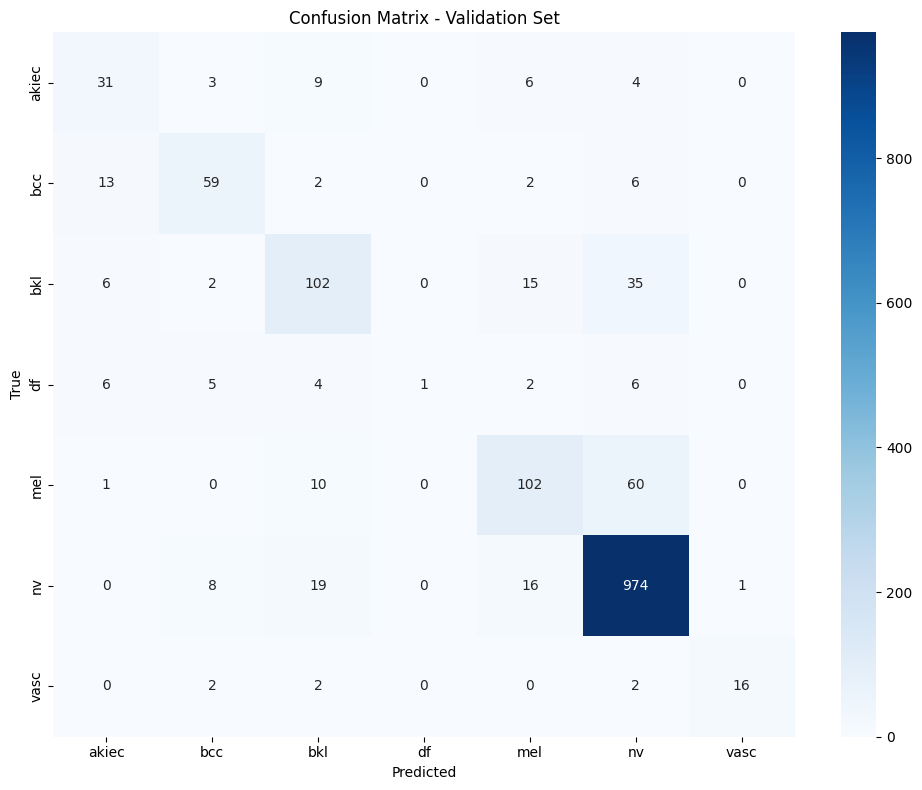

              precision    recall  f1-score   support

       akiec      0.544     0.585     0.564        53
         bcc      0.747     0.720     0.733        82
         bkl      0.689     0.637     0.662       160
          df      1.000     0.042     0.080        24
         mel      0.713     0.590     0.646       173
          nv      0.896     0.957     0.925      1018
        vasc      0.941     0.727     0.821        22

    accuracy                          0.839      1532
   macro avg      0.790     0.608     0.633      1532
weighted avg      0.836     0.839     0.829      1532



In [8]:
model.load_state_dict(torch.load('../models/best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, 
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Validation Set')
plt.tight_layout()
plt.show()

print(classification_report(all_labels, all_preds, 
                          target_names=train_dataset.classes, 
                          digits=3))

In [9]:
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, (cls, acc) in enumerate(zip(train_dataset.classes, class_acc)):
    print(f"{cls:6s}: {acc*100:5.1f}% ({cm[i].sum()} samples)")

akiec :  58.5% (53 samples)
bcc   :  72.0% (82 samples)
bkl   :  63.7% (160 samples)
df    :   4.2% (24 samples)
mel   :  59.0% (173 samples)
nv    :  95.7% (1018 samples)
vasc  :  72.7% (22 samples)


#### 